Linear Regression

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler

import copy
import tensorflow as tf

from sklearn.linear_model import LinearRegression

In [3]:
dataset_cols = ['bike_count', 'hour', 'temp', 'humidity', 'wind', 'visibility', 'dew_pt_temp', 'radiation', 'rain', 'snow', 'functional']


In [4]:
df = pd.read_csv('/content/SeoulBikeData.csv').drop(['Date', 'Holiday', 'Seasons'], axis=1)

df.head()


,Rented Bike Count,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Functioning Day
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Yes
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Yes
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Yes
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Yes
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Yes


In [5]:
df.columns = dataset_cols
df['functional'] = (df['functional']=='Yes').astype(int)
df = df[df['hour']==12]
df = df.drop(['hour'], axis=1)

df.head()


,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


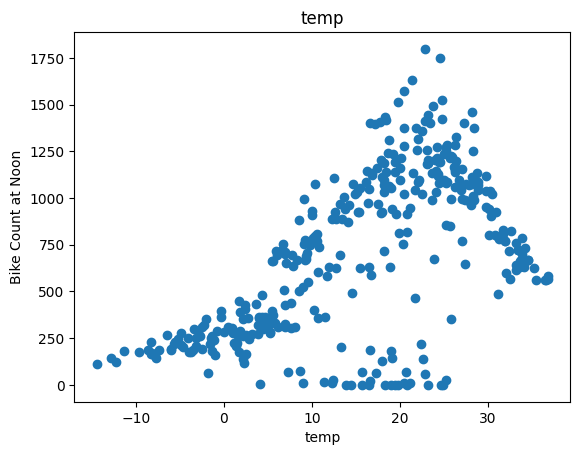

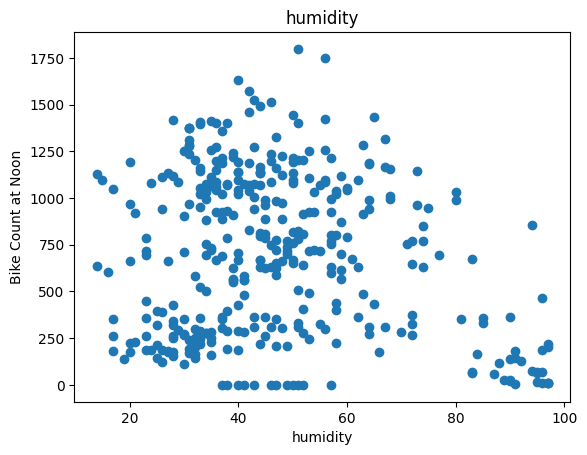

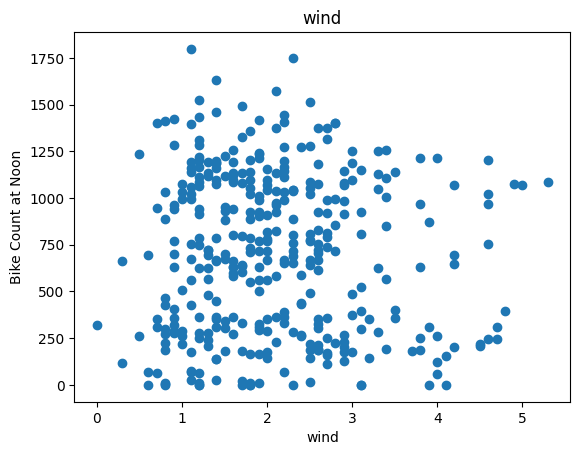

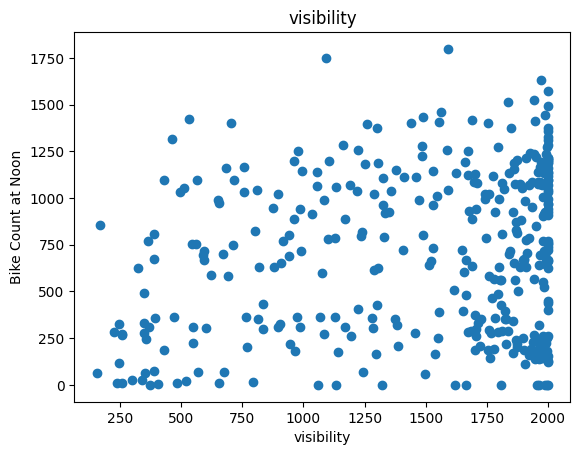

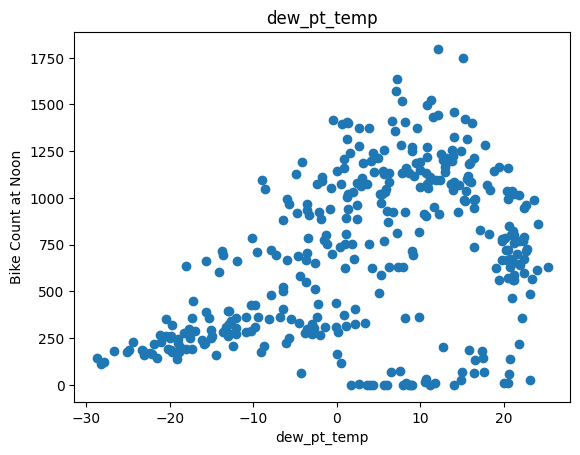

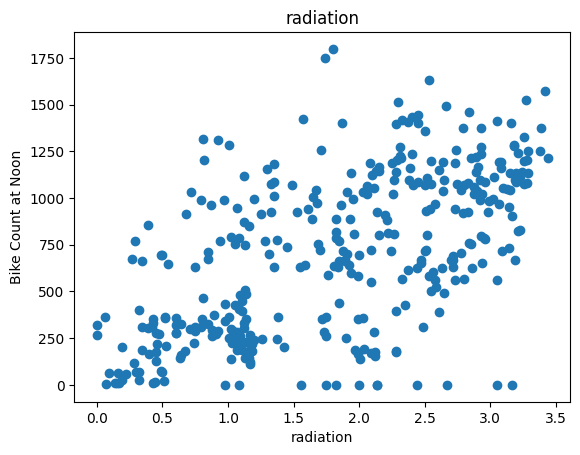

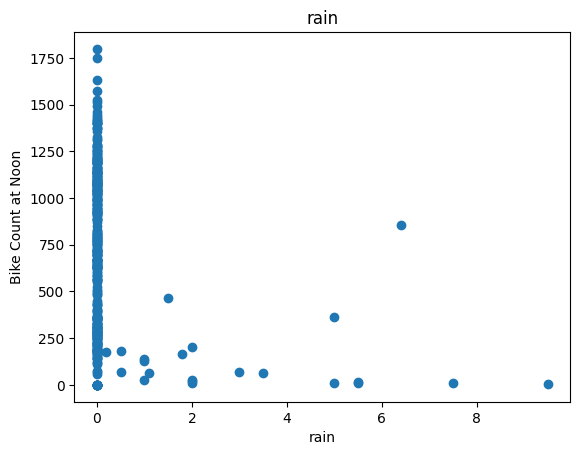

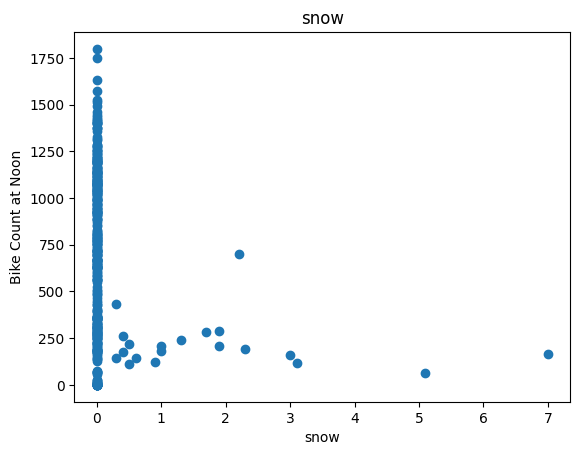

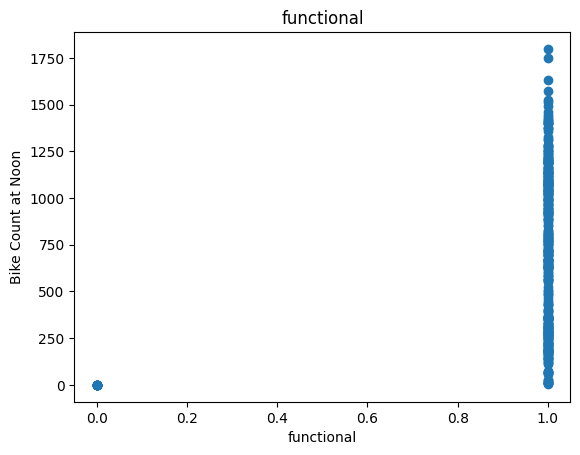

In [6]:
for label in df.columns[1:]:
  plt.scatter(df[label], df['bike_count'])
  plt.title(label)
  plt.ylabel("Bike Count at Noon")
  plt.xlabel(label)
  plt.show()

In [7]:
df = df.drop(['wind', 'visibility', 'functional'], axis=1)
df.head()


,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


In [8]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [9]:
def get_xy(dataframe, y_label, x_label=None):
  dataframe = copy.deepcopy(dataframe)
  if x_label is None:
    X = dataframe[[c for c in dataframe.columns if c != y_label]].values
  else:
    if len(x_label)==1:
      X = dataframe[x_label[0]].values.reshape(-1, 1)
    else:
      X = dataframe[x_label].values

  y = dataframe[y_label].values.reshape(-1,1)
  data = np.hstack((X,y))

  return data, X, y


In [10]:
_, X_train_temp, y_train_temp = get_xy(train, 'bike_count', x_label=['temp'])
_, X_val_temp, y_val_temp = get_xy(val, 'bike_count', x_label=['temp'])
_, X_test_temp, y_test_temp = get_xy(test, 'bike_count', x_label=['temp'])

In [11]:
regressor =LinearRegression()
regressor.fit(X_train_temp, y_train_temp)

LinearRegression()

In [12]:
print(regressor.coef_, regressor.intercept_)

[[21.20412109]] [347.7496518]


In [13]:
regressor.score(X_test_temp, y_test_temp)

0.40456225778821897

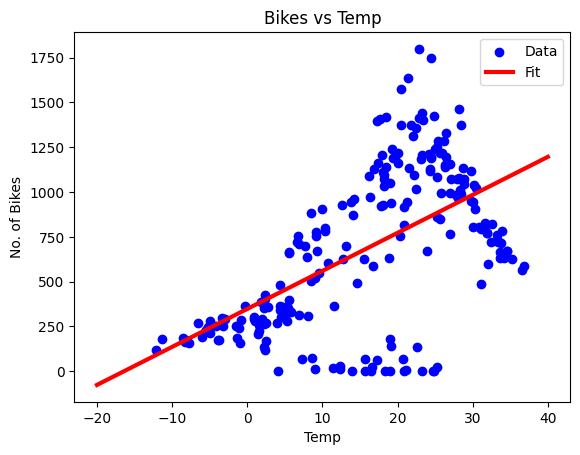

In [14]:
plt.scatter(X_train_temp, y_train_temp, label='Data', color='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, regressor.predict(np.array(x).reshape(-1,1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.title('Bikes vs Temp')
plt.ylabel('No. of Bikes')
plt.xlabel('Temp')
plt.show()

Multiple Linear Regression

In [15]:
_, X_train, y_train = get_xy(train, 'bike_count', x_label=df.columns[1:])
_, X_val, y_val = get_xy(val, 'bike_count', x_label=df.columns[1:])
_, X_test, y_test = get_xy(test, 'bike_count', x_label=df.columns[1:])


In [16]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [17]:
regressor.score(X_test, y_test)

0.5605411059724423

Regression with a NN

In [18]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train.reshape(-1))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:

temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [20]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [21]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1),
    y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(X_val_temp, y_val_temp)
)

In [22]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

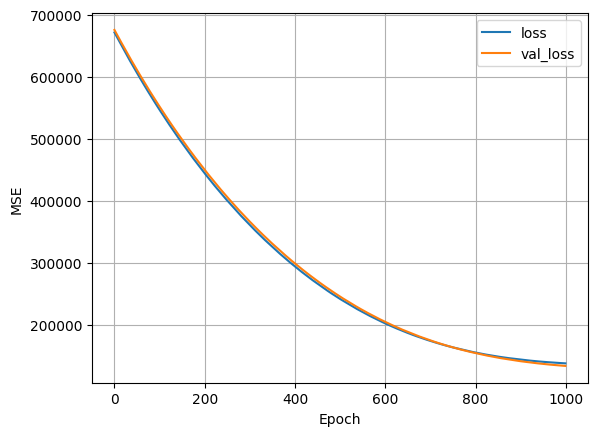

In [23]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


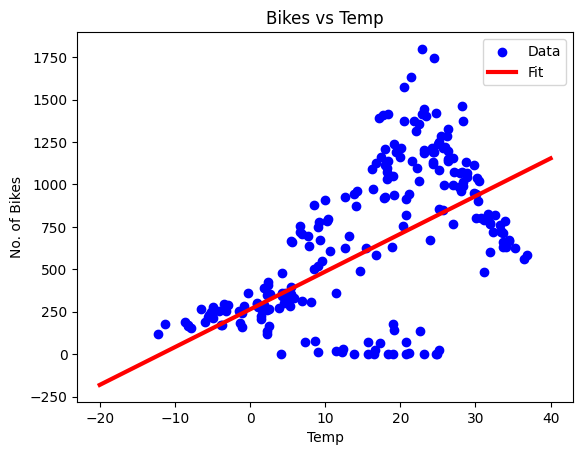

In [24]:
plt.scatter(X_train_temp, y_train_temp, label='Data', color='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1,1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.title('Bikes vs Temp')
plt.ylabel('No. of Bikes')
plt.xlabel('Temp')
plt.show()

In [25]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train.reshape(-1))


In [26]:

nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu'),
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')


In [27]:
history = nn_model.fit(X_train_temp, y_train_temp, validation_data=(X_val_temp, y_val_temp), verbose=0, epochs=100)


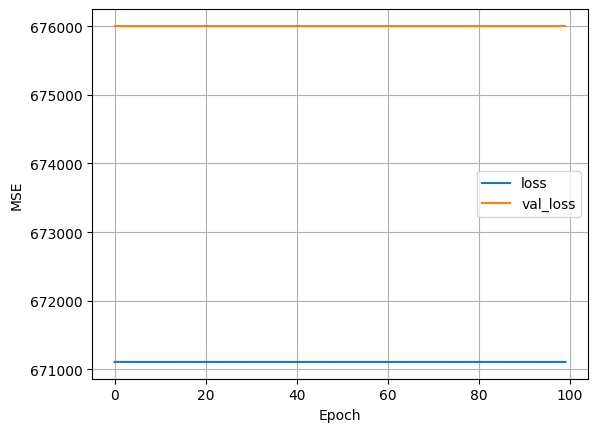

In [28]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


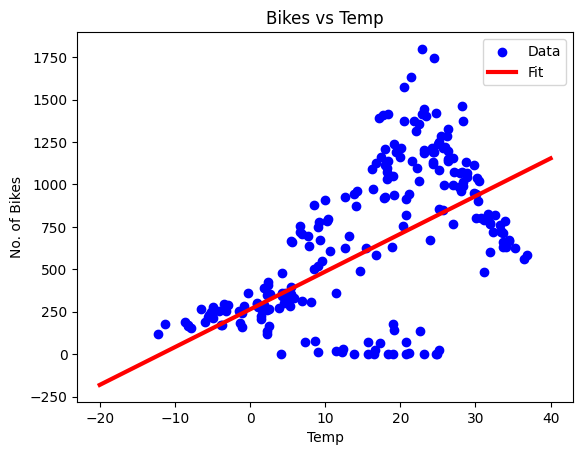

In [29]:
plt.scatter(X_train_temp, y_train_temp, label='Data', color='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1,1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.title('Bikes vs Temp')
plt.ylabel('No. of Bikes')
plt.xlabel('Temp')
plt.show()

In [30]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(X_train)

In [31]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [32]:
history = nn_model.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=0, epochs=100)

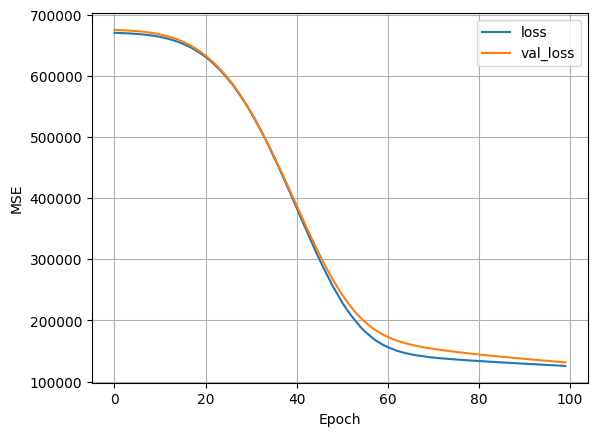

In [33]:
plot_loss(history)

MSE

In [34]:
y_pred_lr = regressor.predict(X_test)
y_pred_nn = nn_model.predict(X_test)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [35]:
def MSE(y_pred, y_real):
  return (np.square(y_pred - y_real)).mean()


In [36]:
MSE(y_pred_lr, y_test)

np.float64(72014.37009355203)

In [37]:
MSE(y_pred_nn, y_test)

np.float64(107310.21063121842)

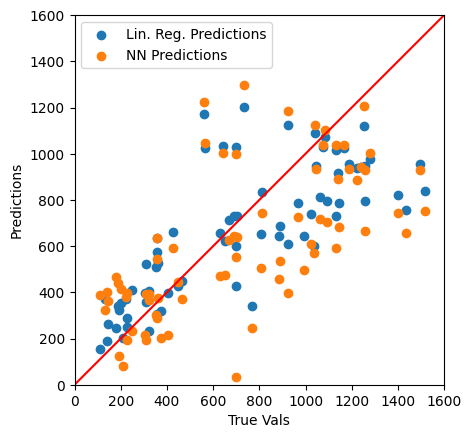

In [38]:
ax = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred_lr, label='Lin. Reg. Predictions')
plt.scatter(y_test, y_pred_nn, label='NN Predictions')
plt.xlabel('True Vals')
plt.ylabel('Predictions')
lims = [0,1600]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c='red')
